# NanoEventsFactory example

Load a single file from x-cache (using redirector_ucsd) or the grid (using redirector_fnal), and play with the events.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
import numpy as np

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

from Tools.config_helpers import redirector_fnal, redirector_ucsd
from Tools.nano_mapping import make_fileset
from Tools.helpers import get_samples

import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

from yahist import Hist1D

import awkward as ak

samples = get_samples("samples_UL18.yaml")
f_in    = samples['/ceph/cms/store/user/dspitzba/ProjectMetis/TTWToLNu_TtoAll_aTtoLep_5f_EFT_NLO_RunIISummer20UL18_NanoAODv9_NANO_v14/']['files'][0]

# load a subset of events
n_max = 5000
events = NanoEventsFactory.from_root(
    f_in,
    schemaclass = NanoAODSchema,
    entry_stop = n_max).events()



## Inspecting default collections

In [11]:
events.Muon.pt

<Array [[7.88], [43.3], ... [], [5.91]] type='5000 * var * float32[parameters={"...'>

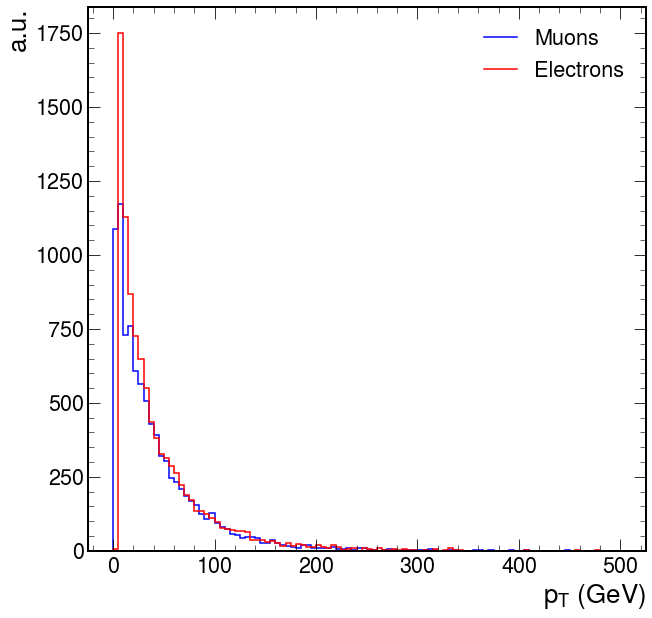

In [13]:
bins = "100,0,500"

muon_pt = Hist1D(ak.flatten(events.Muon.pt), bins=bins, overflow=False)
electron_pt = Hist1D(ak.flatten(events.Electron.pt), bins=bins, overflow=False)
                 
f, ax = plt.subplots()

hep.histplot(
    [muon_pt.counts, electron_pt.counts],
    muon_pt.edges,
    histtype="step",
    stack=False,
    label=[r'Muons', r'Electrons'],
    color=['blue', 'red'],
    ax=ax)

#h.plot()

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$p_{T}\ (GeV)$')

plt.legend()



## Load collections and calculate stuff

In [25]:
from Tools.objects import Collections, getNonPromptFromFlavour, getChargeFlips, prompt, nonprompt, choose, cross, delta_r, delta_r2, match, prompt_no_conv, nonprompt_no_conv, external_conversion, fast_match
from Tools.helpers import pad_and_flatten, mt, fill_multiple, zip_run_lumi_event, get_four_vec_fromPtEtaPhiM, get_samples
from Tools.basic_objects import getJets, getTaus, getIsoTracks, getBTagsDeepFlavB, getFwdJet, getMET
from Tools.selections import Selection, get_pt

In [27]:
presel = ak.num(events.Jet)>2

ev = events[presel]

####################
### Reco objects ###
####################

## Muons
mu_v     = Collections(ev, "Muon", "vetoTTH", year=2018).get()  # these include all muons, tight and fakeable
mu_t     = Collections(ev, "Muon", "tightSSTTH", year=2018).get()
mu_f     = Collections(ev, "Muon", "fakeableSSTTH", year=2018).get()
muon     = ak.concatenate([mu_t, mu_f], axis=1)
muon['p4'] = get_four_vec_fromPtEtaPhiM(muon, get_pt(muon), muon.eta, muon.phi, muon.mass, copy=False)

## Electrons
el_v        = Collections(ev, "Electron", "vetoTTH", year=2018).get()
el_t        = Collections(ev, "Electron", "tightSSTTH", year=2018).get()
el_f        = Collections(ev, "Electron", "fakeableSSTTH", year=2018).get()
electron    = ak.concatenate([el_t, el_f], axis=1)
electron['p4'] = get_four_vec_fromPtEtaPhiM(electron, get_pt(electron), electron.eta, electron.phi, electron.mass, copy=False)


## Merge electrons and muons. These are fakeable leptons now
lepton   = ak.concatenate([muon, electron], axis=1)
#lead_leptons = lepton[ak.argsort(lepton.p4.pt)][:,:3]
leading_lepton_idx = ak.singletons(ak.argmax(lepton.p4.pt, axis=1))
leading_lepton = lepton[leading_lepton_idx]
trailing_lepton_idx = ak.singletons(ak.argmin(lepton.p4.pt, axis=1))
trailing_lepton = lepton[trailing_lepton_idx]

dilepton_mass = (leading_lepton.p4 + trailing_lepton.p4).mass
dilepton_pt = (leading_lepton.p4 + trailing_lepton.p4).pt
#dilepton_dR = delta_r(leading_lepton, trailing_lepton)
dilepton_dR = leading_lepton.p4.delta_r(trailing_lepton.p4)

lepton_pdgId_pt_ordered = ak.fill_none(ak.pad_none(lepton[ak.argsort(lepton.p4.pt, ascending=False)].pdgId, 2, clip=True), 0)

met = getMET(ev, pt_var='pt_nom')

In [29]:
mt_lep_met = mt(lepton.p4.pt, lepton.p4.phi, met.pt, met.phi)
min_mt_lep_met = ak.min(mt_lep_met, axis=1)
max_mt_lep_met = ak.max(mt_lep_met, axis=1)

In [32]:
ak.fill_none(min_mt_lep_met,0)

<Array [12.4, 29.1, 0, ... 56.5, 11.6, 153] type='4999 * float64'>

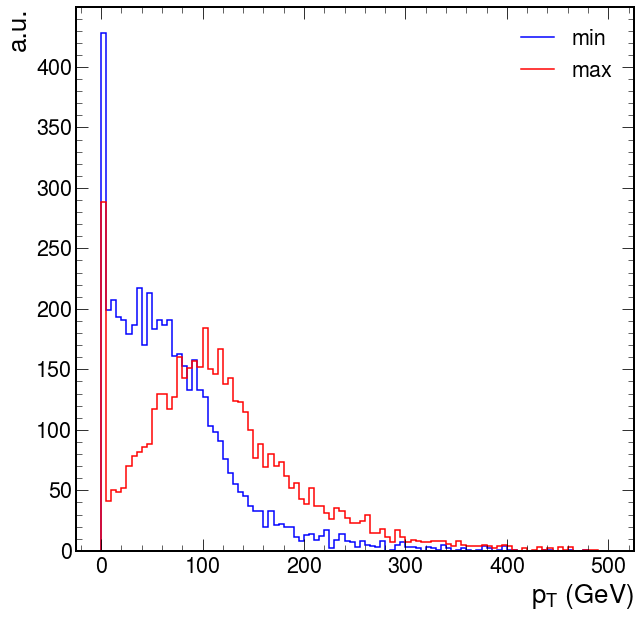

In [33]:
bins = "100,0,500"

mt_min = Hist1D(ak.fill_none(min_mt_lep_met,0), bins=bins, overflow=False)
mt_max = Hist1D(ak.fill_none(max_mt_lep_met,0), bins=bins, overflow=False)
                 
f, ax = plt.subplots()

hep.histplot(
    [mt_min.counts, mt_max.counts],
    mt_min.edges,
    histtype="step",
    stack=False,
    label=[r'min', r'max'],
    color=['blue', 'red'],
    ax=ax)

#h.plot()

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$m_{T}\ (GeV)$')

plt.legend()

# Old development stuff

In [5]:
# 103 weights in UL files
np.sqrt(sum((1-events.LHEPdfWeight[0][1:101])**2))

0.015363986736503797

In [6]:
events.LHEScaleWeight[0]

<Array [1.2, 1.09, 1, ... 1.01, 0.922, 0.843] type='8 * float32[parameters={"__d...'>

In [11]:
np.max(np.abs((1-events.LHEScaleWeight[0][1:101])**2))

0.0392274

In [12]:
from Tools.samples import fs_2018

In [13]:
n_max = 500000
events = NanoEventsFactory.from_root(
    fs_2018['TTW'][0],
    schemaclass = NanoAODSchema,
    entry_stop = n_max).events()

In [24]:
from Tools.helpers import get_four_vec_fromPtEtaPhiM

def getJets(ev, maxEta=100, minPt=25, pt_var='pt', year=2018):
    return ev.Jet[(getattr(ev.Jet, pt_var)>minPt) & (abs(ev.Jet.eta)<maxEta) & (ev.Jet.jetId>1)]

In [27]:
%time
jets = getJets(events, maxEta=100, minPt=25, pt_var='pt_nom')

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 23.4 µs


In [60]:
def getJets(ev, maxEta=100, minPt=25, pt_var='pt', year=2018):
    jets = ev.Jet[(getattr(ev.Jet, pt_var)>minPt) & (abs(ev.Jet.eta)<maxEta) & (ev.Jet.jetId>1)]
    jets = jets[ak.argsort(getattr(jets, pt_var), ascending=False)]
    jets.p4 = get_four_vec_fromPtEtaPhiM(jets, getattr(jets, pt_var), jets.eta, jets.phi, jets.mass, copy=False)
    return jets#[ak.argsort(jets.p4.pt, ascending=False)]

In [61]:
%time
jets = getJets(events, maxEta=100, minPt=25, pt_var='pt_jesTotalUp')

CPU times: user 11 µs, sys: 3 µs, total: 14 µs
Wall time: 26 µs


In [62]:
jets.pt

<Array [[97.6, 78.6, 46.4, ... 60.9, 44, 41.2]] type='208662 * var * float32[par...'>

In [63]:
jets.p4.pt

<Array [[100, 81.4, 48.2, ... 47.3, 42.2]] type='208662 * var * float32[paramete...'>

In [68]:
jets[jets.pt>10].p4

AttributeError: no field named 'p4'

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.3/src/awkward/highlevel.py#L1120)

In [70]:
jets['p5'] = get_four_vec_fromPtEtaPhiM(jets, getattr(jets, 'pt_nom'), jets.eta, jets.phi, jets.mass, copy=False)

In [72]:
jets[jets.pt>10].p5

<PtEtaPhiMLorentzVectorArray [[{pt: 98.9, ... mass: 7.72}]] type='208662 * var *...'>

In [75]:
events.MET.T1_pt_jesTotalUp

<Array [78.1, 68.4, 116, ... 154, 185, 108] type='208662 * float32[parameters={"...'>

In [64]:
high_score_btag = jets[ak.argsort(jets.btagDeepFlavB)][:,:2]

In [66]:
high_score_btag.pt

<Array [[46.4, 32.2], ... [60.9, 41.2]] type='208662 * var * float32[parameters=...'>

In [39]:
def get_ht(events, jet_sel = {'maxEta': 4.7, 'minPt':25}, var='pt_nom'):
    return ak.sum(getJets(events, pt_var=var, **jet_sel).p4.pt, axis=1)

In [41]:
%time
get_ht(events)

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 23.6 µs


<Array [301, 499, 512, 257, ... 458, 832, 370] type='208662 * float32'>

In [48]:
events.MET.T1_phi

<Array [-3, -1.49, -2.9, ... 2.12, -2.69, 1.02] type='208662 * float32[parameter...'>

In [42]:
%time
ak.sum(jets.pt, axis=1)

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 22.6 µs


<Array [295, 494, 507, 255, ... 473, 819, 367] type='208662 * float32'>

In [43]:
get_ht(events, var='pt_jesTotalUp')

<Array [307, 510, 518, 266, ... 494, 851, 376] type='208662 * float32'>

In [84]:
%time

get_four_vec_fromPtEtaPhiM(events.MET, events.MET.pt, ak.zeros_like(events.MET.pt), events.MET.phi, ak.zeros_like(events.MET.pt), copy=False)

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 15.5 µs


<PtEtaPhiMLorentzVectorArray [{pt: 79, eta: 0, ... mass: 0}] type='208662 * PtEt...'>

In [83]:
%time
events.MET.pt

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 16.5 µs


<Array [79, 68, 112, 132, ... 146, 177, 111] type='208662 * float32[parameters={...'>

In [44]:
fs_2018['TTW'][0]

'/hadoop/cms/store/user/dspitzba/nanoAOD/ttw_samples/topW_v0.4.0_dilep/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8_RunIISummer20UL18NanoAODv2-106X_upgrade2018_realistic_v15_L1v1-v1/nanoSkim_1.root'

In [45]:
events.PSWeight[0]

AttributeError: no field named 'PSWeight'

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.3/src/awkward/highlevel.py#L1120)

In [46]:
events.LHEPdfWeight[0]

AttributeError: no field named 'LHEPdfWeight'

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.3/src/awkward/highlevel.py#L1120)

In [20]:
import numpy as np
np.sqrt(sum((1-events.LHEPdfWeight[0])**2))

0.11691895152562129

In [17]:
events.LHEScaleWeight[0]

<Array [1.15, 1.19, 1.24, ... 0.853, 0.879] type='9 * float32[parameters={"__doc...'>

In [2]:
events.Electron.pt

<Array [[34], [58, ... [21.4, 10.5, 10.3]] type='382431 * var * float32[paramete...'>

In [7]:
events.Electron['pt'] = (events.Electron.pt*1.2)
events.Electron['pt']

<Array [[34], [58, ... [21.4, 10.5, 10.3]] type='382431 * var * float32[paramete...'>

In [9]:
from coffea.nanoevents.methods import vector
ak.behavior.update(vector.behavior)

In [18]:
events = events[ak.num(events.Electron)>1]

In [19]:
v = ak.zip(
    {
        "pt": events.Electron.pt*1.2,
        "eta": events.Electron.eta,
        "phi": events.Electron.phi,
        "mass": events.Electron.mass,
    },
    with_name="PtEtaPhiMLorentzVector",
)

#v = PtEtaPhiMLorentzVector(events.Electron.pt*1.2, events.Electron.eta, events.Electron.phi, events.Electron.mass)

In [22]:
(v[:,0:1]+v[:,1:2]).pt

<Array [[64.1], [17.9], ... [27.6], [13.1]] type='170283 * var * float32'>

In [36]:
from Tools.helpers import get_four_vec
test = get_four_vec(events.Electron)

scaler = ak.zip(
    {
        "pt": ak.ones_like(test.pt)*1.2,
        "eta": ak.ones_like(test.pt),
        "phi": ak.ones_like(test.pt),
        "mass": ak.ones_like(test.pt),
    },
    with_name="PtEtaPhiMLorentzVector",
)

In [41]:
scaler.pt

<Array [[1.2, 1.2, 1.2], ... [1.2, 1.2, 1.2]] type='170283 * var * float32'>

In [38]:
test.pt

<Array [[58, 11.9, 5.51, ... 21.4, 10.5, 10.3]] type='170283 * var * float32[par...'>

In [45]:
test.matched_gen

AttributeError: no field named 'matched_gen'

(https://github.com/scikit-hep/awkward-1.0/blob/1.2.3/src/awkward/highlevel.py#L1120)

In [3]:
fileset[list(fileset.keys())[1]][0]

'root://xcache-redirector.t2.ucsd.edu:2040//store/mc/RunIIAutumn18NanoAODv7/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/60000/02232B20-7228-4348-84C7-72DAFDC2CEB7.root'

In [4]:
events.event

<Array [436885, 436871, ... 444644, 444664] type='5000 * uint64[parameters={"__d...'>

In [5]:
ev = events[events.event==4590003]

In [6]:
ak.to_pandas(ev.MET)

,MetUnclustEnUpDeltaX,MetUnclustEnUpDeltaY,covXX,covXY,covYY,fiducialGenPhi,fiducialGenPt,phi,pt,significance,sumEt,sumPtUnclustered
entry,,,,,,,,,,,,


In [57]:
import time

from Tools.objects import Collections

start_time = time.time()
electrons = Collections(events, 'Electron', 'tight', verbose=1).get()
muons = Collections(events, 'Muon', 'tight', verbose=1).get()


delta_time = time.time()-start_time

print ("\nTook %s seconds"%delta_time)


## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0
 - tight electron MVA ID
 - custom multi isolation
 - trigger safe
 - custom ID and multi-isolation
Found 192414 objects passing the selection

## Muon selection for WP tight ##
 - pt >= 15
 - abs(eta) <= 2.4
 - mediumId == 1
 - looseId == 1
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.05
 - abs(sip3d) <= 4
 - ptErrRel <= 0.2
 - custom multi isolation
 - custom multi-isolation
Found 264247 objects passing the selection

Took 57.664668560028076 seconds


In [60]:
from Tools.helpers import pad_and_flatten, mt, fill_multiple, zip_run_lumi_event, get_four_vec_fromPtEtaPhiM
from Tools.selections import get_pt

muons['p4'] = get_four_vec_fromPtEtaPhiM(muons, get_pt(muons), muons.eta, muons.phi, muons.mass, copy=False)

In [70]:
from Tools.objects import choose
dimuon = choose(muons, 2)

In [79]:
dimuon[(ak.num(muons)>1)]['0'].p4

<PtEtaPhiMLorentzVectorArray [[{pt: 39.3, ... mass: 0.106}]] type='35107 * var *...'>

In [69]:
dielectron = choose(electrons, 2)

In [7]:
leptons = ak.concatenate([electrons,muons])

In [8]:
leptons[ak.num(leptons)>1].charge

<Array [[-1, 1], [1, 1], ... [-1, 1], [-1, 1]] type='319 * union[var * int32[par...'>

In [12]:
leptons[((ak.sum(leptons.charge, axis=1)!=0) & (ak.num(leptons)>1))].charge

<Array [[1, 1], [1, 1], ... [1, 1], [1, 1]] type='165 * union[var * int32[parame...'>

In [13]:
leptons[((ak.sum(leptons.charge, axis=1)==0) & (ak.num(leptons)>1))].charge

<Array [[-1, 1], [1, -1], ... [-1, 1], [-1, 1]] type='154 * union[var * int32[pa...'>

In [17]:
ak.max(leptons.pt, axis=1)

<Array [None, 58, None, ... 79.8, 18.2, None] type='10000 * ?float32'>

In [10]:
events[ak.num(muons, axis=1)>0].event

<Array [436885, 436863, ... 444630, 444644] type='1790 * uint64[parameters={"__d...'>

In [7]:
muons.fields

['charge',
 'cleanmask',
 'dxy',
 'dxyErr',
 'dxybs',
 'dz',
 'dzErr',
 'eta',
 'fsrPhotonIdx',
 'fsrPhotonIdxG',
 'genPartFlav',
 'genPartIdx',
 'genPartIdxG',
 'highPtId',
 'highPurity',
 'inTimeMuon',
 'ip3d',
 'isGlobal',
 'isPFcand',
 'isTracker',
 'jetIdx',
 'jetIdxG',
 'jetPtRelv2',
 'jetRelIso',
 'looseId',
 'mass',
 'mediumId',
 'mediumPromptId',
 'miniIsoId',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'multiIsoId',
 'mvaId',
 'mvaLowPt',
 'mvaTTH',
 'nStations',
 'nTrackerLayers',
 'pdgId',
 'pfIsoId',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'pfRelIso04_all',
 'phi',
 'pt',
 'ptErr',
 'segmentComp',
 'sip3d',
 'softId',
 'softMva',
 'softMvaId',
 'tightCharge',
 'tightId',
 'tkIsoId',
 'tkRelIso',
 'triggerIdLoose',
 'tunepRelPt',
 'absMiniIso',
 'ptErrRel',
 'deepJet',
 'jetRelIsoV2',
 'conePt']

In [8]:
fields_to_show = ["pt", "conePt", "eta", "phi", "miniPFRelIso_all", "deepJet"]

ak.to_pandas(muons[events.event==4590009][fields_to_show])

,,pt,conePt,eta,phi,miniPFRelIso_all,deepJet
entry,subentry,,,,,,
0,0,89.001289,91.74375,-1.041992,1.666748,0.0,0.006035


In [9]:
ak.to_pandas(muons[ak.num(muons)>0][fields_to_show])

,,pt,conePt,eta,phi,miniPFRelIso_all,deepJet
entry,subentry,,,,,,
0,0,89.001289,91.743750,-1.041992,1.666748,0.000000,0.006035
1,0,22.520767,23.400000,-0.732056,-2.039551,0.031200,0.014496
2,0,35.408287,38.896875,1.223389,2.832031,0.000000,0.022186
3,0,39.832733,42.187500,-1.335205,-1.277832,0.007453,0.005619
4,0,97.141785,99.843750,-0.975586,-2.340820,0.000000,0.006428
...,...,...,...,...,...,...,...
2285,0,34.735882,35.718750,1.778320,3.064941,0.000000,0.008408
2286,0,81.104309,81.000000,0.807251,0.137268,0.000000,0.004791
2287,0,25.945396,25.101562,-0.316895,0.740234,0.000000,0.013512


You can do anything that you're usually doing inside the processor here as well, so this is very useful for debugging

In [10]:
matched_electrons = electrons[electrons.genPartIdx>=0]
sum(ak.num(matched_electrons, axis=1))

1776

In [11]:
f_in = '/store/mc/RunIIAutumn18NanoAODv7/QCD_Pt-120to170_MuEnrichedPt5_TuneCP5_13TeV_pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/70000/DE335891-829A-B943-99BE-E5A179F5F3EB.root'

events = NanoEventsFactory.from_root(
    redirector_ucsd + f_in,
    schemaclass = NanoAODSchema,
    entry_stop = 9999999).events()

muons = Collections(events, 'Muon', 'tight', verbose=1).get()

single_mu_ev = events[ak.num(muons)>0]

event_list_tight = single_mu_ev.event
event_list_tight


## Muon selection for WP tight ##
 - pt >= 15
 - abs(eta) <= 2.4
 - mediumId == 1
 - looseId == 1
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.05
 - abs(sip3d) <= 4
 - ptErrRel <= 0.2
 - custom multi isolation
 - custom multi-isolation
Found 652 objects passing the selection


<Array [29552, 33557, ... 12024433, 12035747] type='651 * uint64[parameters={"__...'>

In [12]:
import numpy as np
event_selector = (np.zeros_like(events.MET.pt) == 1)

In [13]:
my_events = [29552, 12024433]

In [14]:
for ev in my_events:
    event_selector = (event_selector | (events.event == ev))

In [28]:
mu_df = ak.to_pandas(ak.flatten(muons[event_selector][fields_to_show]))
mu_df

,pt,conePt,eta,phi,miniPFRelIso_all,deepJet
entry,,,,,,
0,22.196507,73.3500,-0.518066,-0.862671,0.101121,0.974121
1,29.695017,93.2625,-1.611572,-1.919434,0.100588,0.124390


In [35]:
ev_df = ak.to_pandas(events.MET[event_selector])
ev_df

,MetUnclustEnUpDeltaX,MetUnclustEnUpDeltaY,covXX,covXY,covYY,fiducialGenPhi,fiducialGenPt,phi,pt,significance,sumEt,sumPtUnclustered
entry,,,,,,,,,,,,
0,-7.730469,-7.636719,860.0,-62.375000,1500.0,-1.039062,9.304688,0.413147,49.778206,2.777344,2454.0,1626.0
1,-5.054688,-2.496094,514.0,-5.484375,390.0,-1.850586,20.265625,-1.706299,52.056957,6.945312,1174.0,1016.0


In [36]:
import pandas as pd
pd.concat([mu_df, ev_df], axis=1, )

,pt,conePt,eta,phi,miniPFRelIso_all,deepJet,MetUnclustEnUpDeltaX,MetUnclustEnUpDeltaY,covXX,covXY,covYY,fiducialGenPhi,fiducialGenPt,phi,pt,significance,sumEt,sumPtUnclustered
entry,,,,,,,,,,,,,,,,,,
0,22.196507,73.3500,-0.518066,-0.862671,0.101121,0.974121,-7.730469,-7.636719,860.0,-62.375000,1500.0,-1.039062,9.304688,0.413147,49.778206,2.777344,2454.0,1626.0
1,29.695017,93.2625,-1.611572,-1.919434,0.100588,0.124390,-5.054688,-2.496094,514.0,-5.484375,390.0,-1.850586,20.265625,-1.706299,52.056957,6.945312,1174.0,1016.0


## Some charge flip work

In [6]:
!wget http://uaf-8.t2.ucsd.edu/~ewallace/chargeflipfull2016.pkl.gz

--2021-06-08 08:49:39--  http://uaf-8.t2.ucsd.edu/~ewallace/chargeflipfull2016.pkl.gz
Resolving uaf-8.t2.ucsd.edu (uaf-8.t2.ucsd.edu)... 169.228.130.7
Connecting to uaf-8.t2.ucsd.edu (uaf-8.t2.ucsd.edu)|169.228.130.7|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 951 [application/x-gzip]
Saving to: ‘chargeflipfull2016.pkl.gz’

100%[======================================>] 951         --.-K/s   in 0s      

2021-06-08 08:49:39 (67.6 MB/s) - ‘chargeflipfull2016.pkl.gz’ saved [951/951]



In [1]:
from Tools.helpers import yahist_2D_lookup
import gzip
import pickle
 
class charge_flip:
    def __init__(self, path):
        self.path = path
        with gzip.open(self.path) as fin:
            self.ratio= pickle.load(fin)
    
    def flip_ratio(self, lepton1, lepton2):
        """takes a dilepton event and weights it based on the 
        odds that one of the leptons has a charge flip"""

        flip1 = yahist_2D_lookup(self.ratio, lepton1.pt, abs(lepton1.eta))
        flip2 = yahist_2D_lookup(self.ratio, lepton2.pt, abs(lepton2.eta))

        flip_rate1 = (ak.prod(flip1, axis = 1) * ak.prod(1/(1-flip1), axis = 1) * ak.prod(1-flip2/(1-flip2), axis = 1)) + (ak.prod(flip2, axis = 1) * ak.prod(1/(1-flip2), axis = 1) * ak.prod(1-flip1/(1-flip1), axis = 1))

        return flip_rate1
    
    def flip_weight(self, electron):

        f_1 = yahist_2D_lookup(self.ratio, electron.pt[:,0:1], abs(electron.eta[:,0:1]))
        f_2 = yahist_2D_lookup(self.ratio, electron.pt[:,1:2], abs(electron.eta[:,1:2]))

        # I'm using ak.prod and ak.sum to replace empty arrays by 1 and 0, respectively
        weight = ak.sum(f_1/(1-f_1), axis=1)*ak.prod(1-f_2/(1-f_2), axis=1) + ak.sum(f_2/(1-f_2), axis=1)*ak.prod(1-f_1/(1-f_1), axis=1)

        return weight

In [2]:
cf = charge_flip('chargeflipfull2016.pkl.gz')

In [61]:
electrons.matched_gen.parent.pdgId

<Array [[], [24], [], [24, ... [], [24], []] type='382431 * var * ?int32[paramet...'>

In [3]:
from Tools.gen import *

In [5]:
import numpy as np
electrons = electrons[electrons.genPartIdx>=0]

ele = electrons[((ak.num(electrons,axis=1)>0))]

not_W_or_tau = ((np.abs(find_first_parent(ele.matched_gen))!=24) & (np.abs(find_first_parent(ele.matched_gen))!=15))
not_W_or_tau = ((np.abs(find_first_parent(ele.matched_gen))!=24) & (np.abs(find_first_parent(ele.matched_gen))!=15))

In [63]:
ak.flatten(ele[not_W_or_tau])

<ElectronArray [Electron, Electron, ... Electron] type='1030 * ?electron'>

In [64]:
find_first_parent(ak.flatten(ele[not_W_or_tau].matched_gen))

<Array [2, 1, -2, -1, 2, ... 21, 2, 2, -1, 1] type='1030 * ?int64'>

In [69]:
potential_flip = (abs(find_first_parent(ele.matched_gen)) == 21)

In [70]:
ak.flatten(ele[potential_flip])

<ElectronArray [Electron, Electron, ... None, Electron] type='162 * ?electron'>

In [67]:
electrons

<ElectronArray [[], [Electron], ... [Electron], []] type='382431 * var * electron'>

In [71]:
(162+53)/382431

0.000562192918461108

In [4]:

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

from Tools.config_helpers import redirector_fnal, redirector_ucsd
from Tools.nano_mapping import make_fileset
from Tools.helpers import get_samples

import awkward as ak

samples = get_samples()

fileset = make_fileset(['top'], samples, redirector=redirector_ucsd, small=True) # changed top -> TTW

# load a subset of events
n_max = 500000
events = NanoEventsFactory.from_root(
    fileset[list(fileset.keys())[0]][0],
    schemaclass = NanoAODSchema,
    #entry_stop = n_max,
).events()

from Tools.objects import Collections
from Tools.gen import *

#electrons = Collections(events, 'Electron', 'tight', verbose=1).get()
#electrons = electrons[electrons.genPartIdx>=0]
#ele = electrons[((ak.num(electrons,axis=1)==2))]

#SM_particles = 
#charge_list = 
def get_charge_parent(particle):
    parent = find_first_parent(particle)
    out_charge = ak.zeros_like(parent)
    charge_pairs = [(11,-1), (13,-1), (24, 1)]
    for pdg, charge in charge_pairs:
        out_charge = (parent==pdg)*ak.ones_like(parent)*(charge) + (~(parent==pdg))*out_charge
    return out_charge


#get_charge_parent(ele.matched_gen)

In [9]:
fileset[list(fileset.keys())[0]][0]

'root://xcache-redirector.t2.ucsd.edu:2042//store/mc/RunIIAutumn18NanoAODv7/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21-v1/60000/022107FA-F567-1B44-B139-A18ADC996FCF.root'

In [11]:
electrons = Collections(events, 'Electron', 'tight', verbose=1).get()

# only gen matched electrons
electrons = electrons[electrons.genPartIdx>=0]

# require exactly two electrons
ele = electrons[((ak.num(electrons,axis=1)==2)&(ak.sum(electrons.charge, axis=1)!=0))]

# how many are left?
len(ele)


## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0
 - tight electron MVA ID
 - custom multi isolation
 - trigger safe
 - custom ID and multi-isolation
Found 418141 objects passing the selection


74

In [5]:
import numpy as np

electron = Collections(events, 'Electron', 'tight', verbose=1).get()
electron = electron[(electron.pt > 20) & (np.abs(electron.eta) < 2.4)]
electron = electron[(electron.genPartIdx >= 0)] #from here on all leptons are gen-matched
electron = electron[(np.abs(electron.matched_gen.pdgId)==11)]
electron = electron[( (electron.genPartFlav==1) | (electron.genPartFlav==15) )] #and now they are all prompt

electron = electron[((ak.num(electron,axis=1)==2)&(ak.sum(electron.charge, axis=1)!=0))]

print ("Number of events with prompt SS:", len(electron))

flipped = (electron.pdgId*(-1) == electron.matched_gen.pdgId)
flipped_electron = electron[flipped]

len(electron[(ak.num(flipped_electron, axis=1)>0)])




## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0
 - tight electron MVA ID
 - custom multi isolation
 - trigger safe
 - custom ID and multi-isolation
Found 418141 objects passing the selection
Number of events with prompt SS: 21


18

In [6]:
ak.num(electron)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='21 * int64'>

In [7]:
cf.flip_weight(electron)

<Array [0.00496, 4.07e-05, ... 0.00193] type='21 * float64'>

In [3]:
ak.num(flipped_electron)

<Array [1, 0, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='21 * int64'>

In [9]:
events.genWeight

<Array [72.7, 72.7, 72.7, ... 72.7, 72.7, 72.7] type='1140000 * float32[paramete...'>

In [4]:
is_flipped = ( ( (electron.matched_gen.pdgId*(-1) == electron.pdgId) | (find_first_parent(electron.matched_gen)*(-1) == electron.pdgId) ) & (np.abs(electron.pdgId) == 11) )
        
        
flipped_electron = electron[is_flipped]
flipped_electron = flipped_electron[(ak.fill_none(flipped_electron.pt, 0)>0)]
flipped_electron = flipped_electron[~(ak.is_none(flipped_electron))]
n_flips = ak.num(flipped_electron)

In [5]:
n_flips

<Array [1, 0, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='21 * int64'>

In [23]:
electron = Collections(events, 'Electron', 'tight', verbose=1).get()
electron = electron[(electron.pt > 20) & (np.abs(electron.eta) < 2.4)]
electron = electron[(electron.genPartIdx >= 0)] #from here on all leptons are gen-matched
electron = electron[(np.abs(electron.matched_gen.pdgId)==11)]
electron = electron[( (electron.genPartFlav==1) | (electron.genPartFlav==15) )] #and now they are all prompt

flipped = (electron.pdgId*(-1) == electron.matched_gen.pdgId)
flipped_electron = electron[flipped]


## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0
 - tight electron MVA ID
 - custom multi isolation
 - trigger safe
 - custom ID and multi-isolation
Found 418141 objects passing the selection


In [24]:
non_flip_events = events[((ak.num(electron, axis=1)==2)&(ak.sum(electron.charge, axis=1)!=0)&(ak.num(flipped_electron, axis=1)==0))]
non_flip_events.event

<Array [6853556, 33539380, 64376350] type='3 * uint64[parameters={"__doc__": "ev...'>

In [14]:
ak.num(electron, axis=1)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='21 * int64'>

In [13]:
non_flip_events.Electron.pt

<Array [[9.83], [17.5], [15.7]] type='3 * var * float32[parameters={"__doc__": "...'>

In [ ]:
flipped_electron = electron[flipped]

In [8]:
non_flip_events.luminosityBlock

<Array [919, 919, 919] type='3 * uint32[parameters={"__doc__": "luminosityBlock/...'>

In [23]:
for x in find_first_parent(electron.matched_gen):
    print (x)

[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[-24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]
[-24, -24]
[-15, -24]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[-24, 24]
[24, -24]
[24, -24]
[-24, 24]


In [15]:
electron.matched_gen.pdgId

<Array [[-11, 11], [-11, ... -11], [-11, 11]] type='28 * var * ?int32[parameters...'>

In [5]:
prompt = ele[((ele.genPartFlav==1)|(ele.genPartFlav==15))]

In [7]:
ele[(ak.num(prompt, axis=1)==2)]

<ElectronArray [[Electron, Electron, ... Electron]] type='28 * var * electron'>

In [3]:
# check that this is really all SS
ele.charge

<Array [[1, 1], [1, 1], ... [-1, -1], [-1, -1]] type='74 * var * int32[parameter...'>

In [4]:
ele.pdgId*(-1) == ele.matched_gen.pdgId

<Array [[True, True], ... [False, True]] type='74 * var * ?bool'>

In [5]:
ak.num((ele.pdgId == ele.matched_gen.pdgId), axis=1)

<Array [2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2] type='74 * int64'>

In [15]:
ele.pdgId

<Array [[-11, -11], [-11, ... 11], [11, 11]] type='29 * var * int32[parameters={...'>

In [16]:
ele.matched_gen.pdgId

<Array [[-11, -11], [-11, ... 11], [11, 11]] type='29 * var * ?int32[parameters=...'>

In [6]:
flipped_ele = ele[(ele.pdgId*(-1) == ele.matched_gen.pdgId)]

In [7]:
ak.num(flipped_ele, axis=1)

<Array [0, 0, 0, 0, 1, 0, ... 0, 1, 0, 0, 1, 1] type='74 * int64'>

In [8]:
# flipped electrons
sum(ak.num(flipped_ele, axis=1))

23

In [9]:
# total events with SS
len(flipped_ele)

74

In [10]:
parents = find_first_parent(ele.matched_gen)

In [11]:
print (parents)

[[24, -511], [24, 531], [24, -5132], [24, ... 511], [-521, 15], [-24, 24], [24, -24]]


In [12]:
non_prompt = ele[abs(parents)>24]

In [14]:
sum(ak.num(non_prompt))

45

In [19]:
prompt = ele[abs(parents)<25]

In [20]:
ak.num(prompt)

<Array [1, 1, 1, 1, 2, 2, ... 1, 2, 1, 1, 2, 2] type='74 * int64'>

In [23]:
diprompt = ele[(ak.num(prompt, axis=1)==2)]
len(diprompt)

29

In [24]:
flipped_prompt = diprompt[(diprompt.pdgId*(-1) == diprompt.matched_gen.pdgId)]
sum(ak.num(flipped_prompt, axis=1))
#diprompt

23

In [25]:
parents = find_first_parent(diprompt.matched_gen)
print(parents)

[[24, -24], [-24, 24], [24, 1], [24, -24, ... 24], [24, -24], [-24, 24], [24, -24]]


In [26]:
for pair in parents:
    print (pair)

[24, -24]
[-24, 24]
[24, 1]
[24, -24]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[-24, -24]
[24, -6]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]
[24, -24]
[-24, -24]
[-15, -24]
[24, -5]
[-24, -15]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]


In [27]:
for ch in diprompt.charge:
    print (ch)

[-1, -1]
[1, 1]
[1, 1]
[-1, -1]
[-1, -1]
[-1, -1]
[-1, -1]
[1, 1]
[-1, -1]
[1, 1]
[1, 1]
[-1, -1]
[-1, -1]
[1, 1]
[-1, -1]
[-1, -1]
[-1, -1]
[1, 1]
[-1, -1]
[-1, -1]
[-1, -1]
[1, 1]
[-1, -1]
[-1, -1]
[-1, -1]
[1, 1]
[-1, -1]
[-1, -1]
[-1, -1]


In [29]:
for pair in find_first_parent(diprompt[(ak.num(flipped_prompt, axis=1)>0)].matched_gen):
    print (pair)

[24, -24]
[24, -24]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]
[24, -24]
[-15, -24]
[-24, -15]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]
[-24, 24]
[24, -24]


# Trilep checks

In [45]:
#f_in = 'root://xcache-redirector.t2.ucsd.edu:2042//store/mc/RunIIAutumn18NanoAODv7/TTWJetsToLNu_TuneCP5_13TeV-amcatnloFXFX-madspin-pythia8/NANOAODSIM/Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/60000/02232B20-7228-4348-84C7-72DAFDC2CEB7.root'
f_in = 'root://xcache-redirector.t2.ucsd.edu:2042//store/mc/RunIISummer20UL18NanoAODv2/TTZToLLNuNu_M-10_TuneCP5_13TeV-amcatnlo-pythia8/NANOAODSIM/106X_upgrade2018_realistic_v15_L1v1-v1/30000/13C6DDDD-1DE7-CB48-AC06-9B28CC47D344.root'

events = NanoEventsFactory.from_root(
    f_in,
    schemaclass = NanoAODSchema,
    #entry_stop = n_max,
).events()


In [46]:
electron = Collections(events, 'Electron', 'tight', verbose=1).get()
muon = Collections(events, 'Muon', 'tight', verbose=1).get()


## Electron selection for WP tight ##
 - pt >= 15
 - abs(etaSC) <= 2.5
 - convVeto == 1
 - lostHits == 0
 - tightCharge == 2
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.1
 - abs(sip3d) <= 4.0
 - tight electron MVA ID
 - custom multi isolation
 - trigger safe
 - custom ID and multi-isolation
Found 284052 objects passing the selection

## Muon selection for WP tight ##
 - pt >= 15
 - abs(eta) <= 2.4
 - mediumId == 1
 - looseId == 1
 - abs(dxy) <= 0.05
 - abs(dz) <= 0.05
 - abs(sip3d) <= 4
 - ptErrRel <= 0.2
 - custom multi isolation
 - custom multi-isolation
Found 383144 objects passing the selection


In [47]:
trilep_events = events[((ak.num(electron, axis=1)+ak.num(muon, axis=1))==3)]

In [48]:
len(trilep_events)

33869

In [49]:
from Tools.objects import choose

dimu_veto = choose(muon,2)
diele_veto = choose(electron,2)
OS_dimu_veto = dimu_veto[(dimu_veto['0'].charge*dimu_veto['1'].charge < 0)]
OS_diele_veto = diele_veto[(diele_veto['0'].charge*diele_veto['1'].charge < 0)]


In [50]:
OS_dimu_veto

<CandidateArray [[], [], [], ... '0': Muon, '1': Muon}]] type='1018000 * var * C...'>

In [51]:
SFOS = ak.concatenate([OS_diele_veto, OS_dimu_veto], axis=1)

In [52]:
events[((ak.num(SFOS)>0)&((ak.num(electron, axis=1)+ak.num(muon, axis=1))==3))]

<NanoEventsArray [<event 1:35:34152>, ... ] type='33080 * event'>

In [53]:
33080/33869

0.9767043609200153

In [38]:
2804/3749

0.7479327820752201

In [54]:
events[((ak.num(SFOS)==0)&((ak.num(electron, axis=1)+ak.num(muon, axis=1))==3))]

<NanoEventsArray [<event 1:35:34395>, ... ] type='789 * event'>

In [40]:
945/3749

0.25206721792477993

In [55]:
events[((ak.sum(electron.charge, axis=1)+(ak.sum(muon.charge, axis=1))<0)&((ak.num(electron, axis=1)+ak.num(muon, axis=1))==3))]

<NanoEventsArray [<event 1:35:34189>, ... ] type='17010 * event'>

In [56]:
17010/33869

0.5022291771236234

# Sample validation

In [1]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import Weights, PackedSelection

from Tools.config_helpers import redirector_fnal, redirector_ucsd

import awkward as ak

f_in = '/store/mc/RunIISummer20UL17NanoAODv2/WZTo3LNu_mllmin01_NNPDF31_TuneCP5_13TeV_powheg_pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/50000/D613B3F6-C909-9A46-BC99-59CC6FF21223.root'

# load a subset of events
n_max = 500000
events_UL = NanoEventsFactory.from_root(
    redirector_ucsd+f_in,
    schemaclass = NanoAODSchema,
    entry_stop = n_max).events()



In [38]:
from Tools.objects import choose
from yahist import Hist1D

dimuon_UL = choose(events_UL.Muon, 2)

In [59]:
bins = [ x for x in range(0,200,2)]
Hist1D(ak.flatten(dimuon_UL[ak.num(dimuon_UL)>0].mass), bins=bins)

[2329.00 ± 48.26   3165.00 ± 56.26   14262.00 ± 119.42   11493.00 ± 107.21
 9831.00 ± 99.15   8273.00 ± 90.96   7182.00 ± 84.75   6479.00 ± 80.49
 5795.00 ± 76.12   5149.00 ± 71.76   4712.00 ± 68.64   4319.00 ± 65.72
 3879.00 ± 62.28   3416.00 ± 58.45   3046.00 ± 55.19   2807.00 ± 52.98
 2612.00 ± 51.11   2440.00 ± 49.40   2182.00 ± 46.71   2020.00 ± 44.94
 1785.00 ± 42.25   1850.00 ± 43.01   1671.00 ± 40.88   1618.00 ± 40.22
 1357.00 ± 36.84   1394.00 ± 37.34   1320.00 ± 36.33   1289.00 ± 35.90
 1199.00 ± 34.63   1208.00 ± 34.76   1145.00 ± 33.84   1103.00 ± 33.21
 1031.00 ± 32.11   995.00 ± 31.54   1060.00 ± 32.56   956.00 ± 30.92
 1003.00 ± 31.67   988.00 ± 31.43   967.00 ± 31.10   1017.00 ± 31.89
 1160.00 ± 34.06   1373.00 ± 37.05   1895.00 ± 43.53   2953.00 ± 54.34
 6301.00 ± 79.38   9937.00 ± 99.68   6310.00 ± 79.44   2668.00 ± 51.65
 1387.00 ± 37.24   958.00 ± 30.95   734.00 ± 27.09   585.00 ± 24.19
 559.00 ± 23.64   487.00 ± 22.07   461.00 ± 21.47   376.00 ± 19.39
 356.00 ± 18.87   373.00 ± 19.31   380.00 ± 19.49   351.00 ± 18.73
 336.00 ± 18.33   344.00 ± 18.55   316.00 ± 17.78   300.00 ± 17.32
 299.00 ± 17.29   265.00 ± 16.28   236.00 ± 15.36   220.00 ± 14.83
 254.00 ± 15.94   246.00 ± 15.68   250.00 ± 15.81   208.00 ± 14.42
 215.00 ± 14.66   220.00 ± 14.83   175.00 ± 13.23   175.00 ± 13.23
 192.00 ± 13.86   175.00 ± 13.23   167.00 ± 12.92   157.00 ± 12.53
 163.00 ± 12.77   130.00 ± 11.40   124.00 ± 11.14   158.00 ± 12.57
 114.00 ± 10.68   127.00 ± 11.27   130.00 ± 11.40   120.00 ± 10.95
 99.00 ± 9.95   115.00 ± 10.72   104.00 ± 10.20   107.00 ± 10.34
 114.00 ± 10.68   96.00 ± 9.80   91.00 ± 9.54   88.00 ± 9.38
 107.00 ± 10.34   103.00 ± 10.15   3113.00 ± 55.79]

In [58]:
bins = [ x/10. for x in range(0,200,1)]
h_UL = Hist1D(ak.flatten(dimuon_UL[ak.num(dimuon_UL)>0].mass), bins=bins, overflow=False)

In [42]:
f_in = '/store/mc/RunIISummer16NanoAODv7/WZTo3LNu_mllmin01_13TeV-powheg-pythia8/NANOAODSIM/PUMoriond17_Nano02Apr2020_102X_mcRun2_asymptotic_v8-v1/70000/5023ABC1-B4D7-D749-BD69-7EA689C7D3B6.root'

# load a subset of events
n_max = 500000
events = NanoEventsFactory.from_root(
    redirector_ucsd+f_in,
    schemaclass = NanoAODSchema,
    entry_stop = n_max).events()

dimuon = choose(events.Muon, 2)
bins = [ x/10. for x in range(0,200,1)]

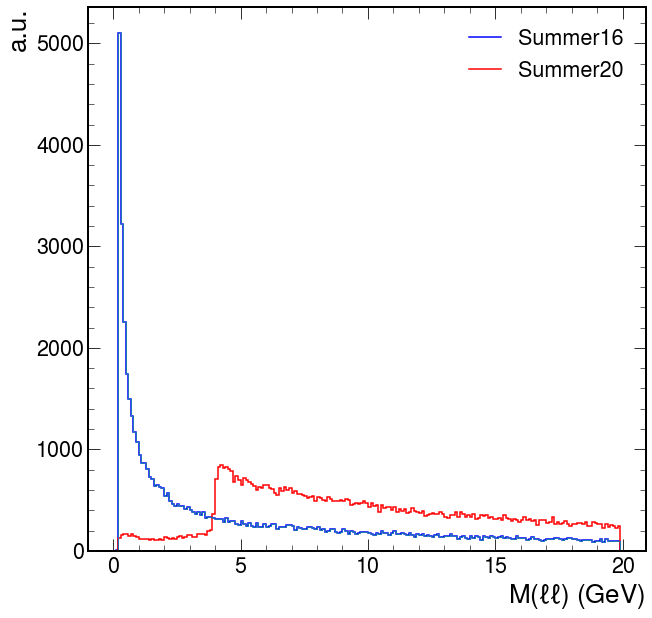

In [56]:
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

h = Hist1D(ak.flatten(dimuon[ak.num(dimuon)>0].mass), bins=bins, overflow=False)

f, ax = plt.subplots()

hep.histplot(
    #[(h/sum(h.counts)).counts, (h_UL/sum(h_UL.counts)).counts],
    [h.counts, h_UL.counts],
    h.edges,
    #w2=[my_histos['tch'].errors/100, my_histos['tuh'].errors/100],
    histtype="step",
    stack=False,
    label=[r'Summer16', r'Summer20'],
    color=['blue', 'red'],
    #density=[True, True],
    ax=ax)

h.plot()

ax.set_ylabel(r'a.u.')
ax.set_xlabel(r'$M(\ell\ell)\ (GeV)$')

plt.legend()

f.savefig('/home/users/dspitzba/public_html/WZ_minmll.png')

In [51]:
sum(h.counts)

60370.0

In [60]:
events_UL.Jet.jetId

<Array [[6], [6], [0, ... 2, 6, 6, 6, 6, 6, 6]] type='500000 * var * int32[param...'>

In [63]:
events.Flag.ecalBadCalibFilter

<Array [True, True, True, ... True, True, True] type='500000 * bool[parameters={...'>

In [4]:
events_UL.HLT.Ele32_WPTight_Gsf

<Array [False, False, False, ... False, True] type='500000 * bool[parameters={"_...'>